In [ ]:
# !pip install torch torchvision

In [1]:
import numpy as np 
import pandas as pd
import os
import glob
import numpy as np
import scipy.misc
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os
import glob
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

#geojson
import folium
import json

2024-05-21 09:58:47.864047: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 09:58:47.864172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 09:58:48.037945: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
input_path_images = "../input/onera-satellite-change-detection-dataset/images/Onera Satellite Change Detection dataset - Images"
input_path_labels = "../input/onera-satellite-change-detection-dataset/train_labels/Onera Satellite Change Detection dataset - Train Labels"

In [3]:
cities_all = [f.name for f in os.scandir(input_path_images) if f.is_dir()]
cities_train = [f.name for f in os.scandir(input_path_labels) if f.is_dir()]

For each location, folders imgs_1_rect and imgs_2_rect contain the same images as imgs_1 and imgs_2 resampled at 10m resolution and cropped accordingly for ease of use. The proposed split into train and test images is contained in the train.txt and test.txt files.

In [23]:
sample = 3 #abudhabi
path = os.path.join(input_path_images,cities_train[sample],"imgs_1_rect")

In [24]:
tifs = []
for file_name in os.listdir(path):
    tifs.append(os.path.join(path, file_name))

In [25]:
geojson_file_path = os.path.join(input_path_images,cities_train[sample],"abudhabi.geojson")
with open(geojson_file_path) as f:
    geojson_data = json.load(f)

coordinates = geojson_data['features'][0]['geometry']['coordinates'][0]

center_coordinates = [sum(x[1] for x in coordinates) / len(coordinates), sum(x[0] for x in coordinates) / len(coordinates)]
my_map = folium.Map(location=center_coordinates, zoom_start=12)

folium.GeoJson(geojson_data).add_to(my_map)

# display(my_map)

In [26]:
def load_tif(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1), src.transform

In [27]:
im1_path = os.path.join(input_path_images,cities_train[sample],"pair","img1.png")
im1 = Image.open(im1_path)
im2_path = os.path.join(input_path_images,cities_train[sample],"pair","img2.png")
im2 = Image.open(im2_path)
lab_path = os.path.join(input_path_labels,"abudhabi","cm","cm.png")
lab = Image.open(lab_path)
tiffs = [load_tif(tif) for tif in tifs]

/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


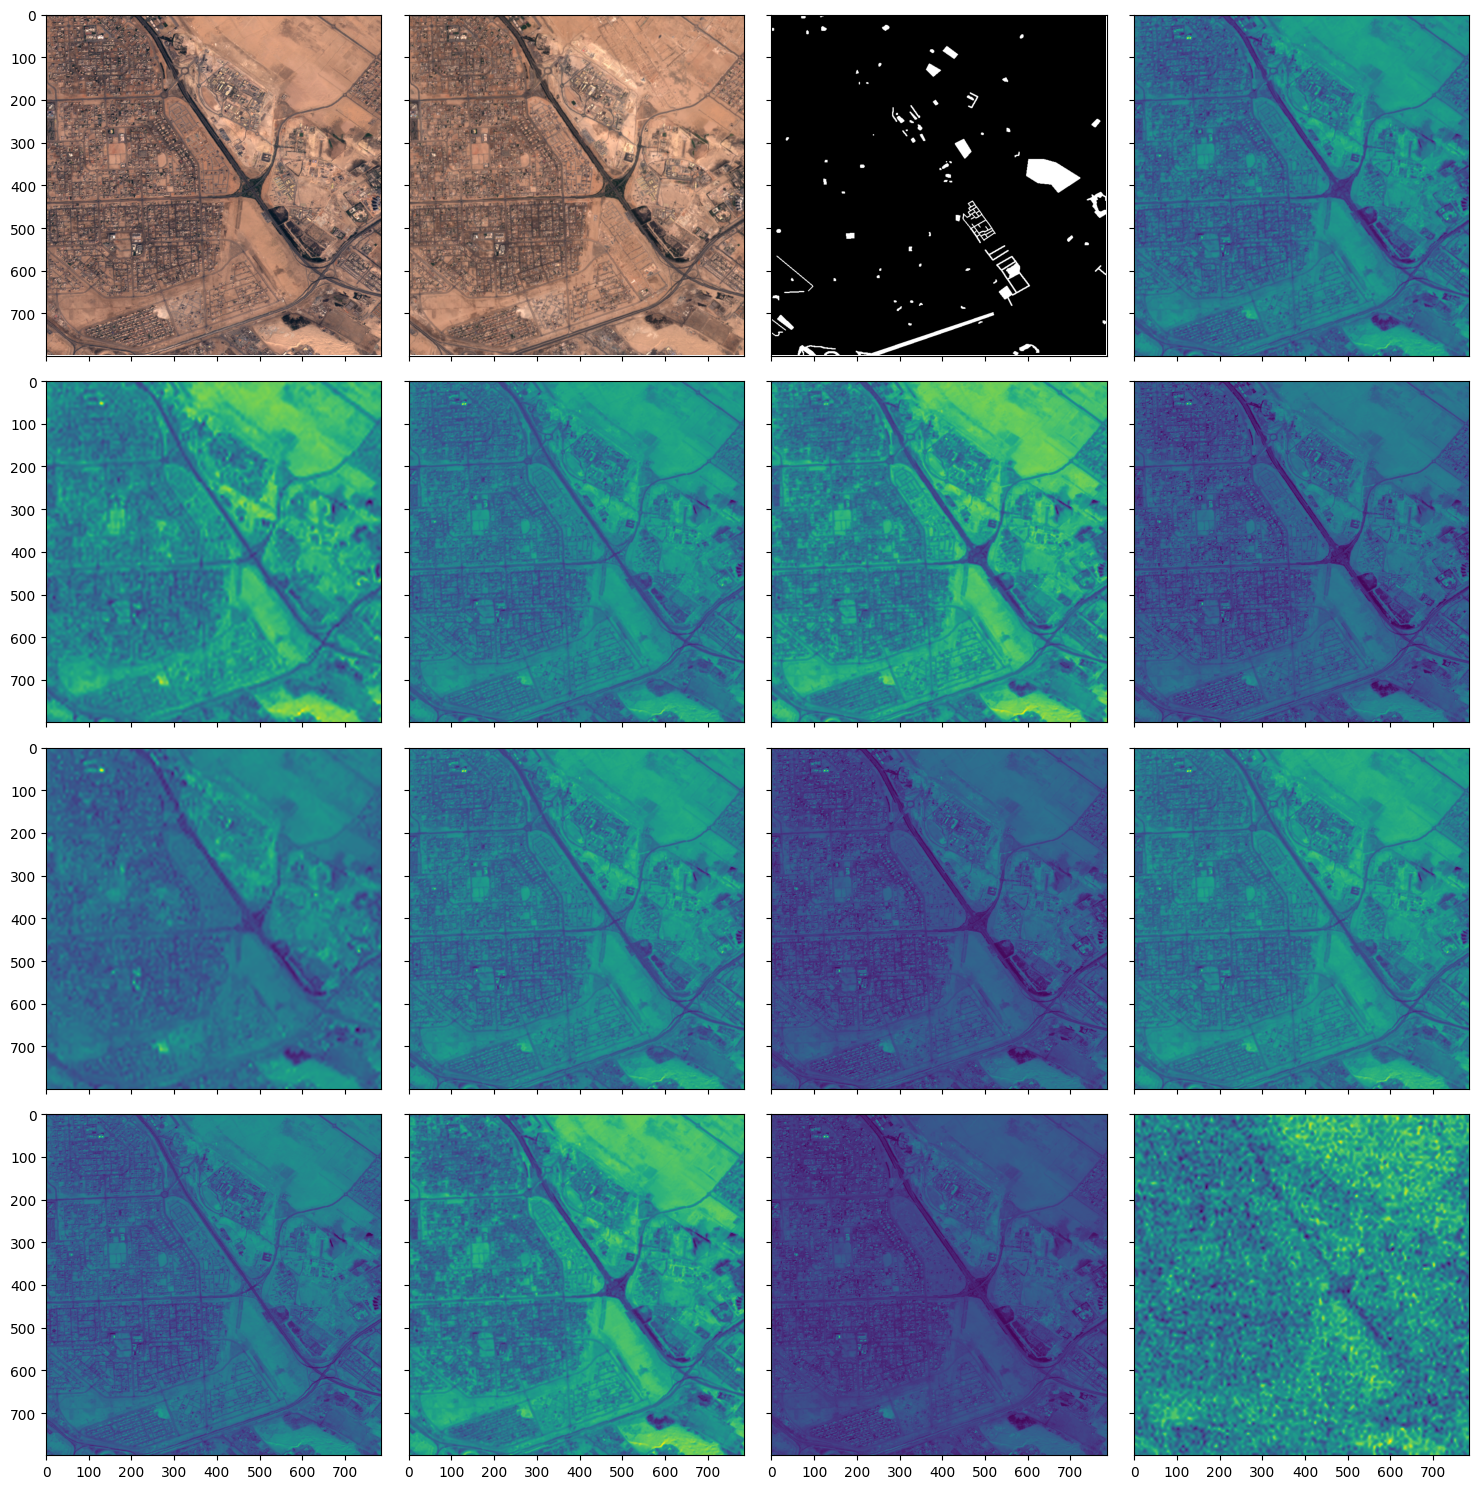

In [9]:
fig, axes = plt.subplots(4, 4, figsize=(15, 15), sharex='all', sharey='all', subplot_kw={'aspect': 'auto'})
axes = axes.flatten()

axes[0].imshow(im1)
axes[1].imshow(im2)
axes[2].imshow(lab)

for ax, (image, transform) in zip(axes[3:], tiffs):
    show(image, ax=ax, transform=transform)

plt.tight_layout()
plt.show()

https://www.mdpi.com/2072-4292/12/12/2010

https://www.azavea.com/blog/2022/04/18/change-detection-with-raster-vision/

### Shapes

In [ ]:
# for img in imgs2015:
#     print(img)
#     print(cv2.imread(img).shape)

### DATA

In [4]:
def load_and_normalize(image_path, target_shape):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_shape)
    image = image / 255.0
    return image

In [5]:
def load_and_normalize_cm(image_path, target_shape):
    img = Image.open(image_path)
    img = img.resize(target_shape)
    binary_array = np.array(img, dtype=np.uint8)

    if img.mode != '1':
        img = img.convert('1')
        binary_array = np.array(img, dtype=np.uint8)
    
    return binary_array

In [6]:
def load_images(cities_train,input_path,year_index=1,labels=False,target_shape = (512,512),sample=False,print_=False):
    images = []
    for city in cities_train:
        if print_:
                print(city)
                
        path = os.path.join(input_path,city)
#         path_tifs = os.path.join(path,f"imgs_{i}_rect")
#         tifs = [os.path.join(path_tifs,f) for f in os.listdir(path_tifs)]
        if labels:
            path = os.path.join(path,"cm","cm.png")
            img = load_and_normalize_cm(path,target_shape)
        else:
            path = os.path.join(path,"pair",f"img{year_index}.png")
            img = load_and_normalize(path,target_shape)
        
        images.append(img)
        if sample:
            break
    return np.stack(images, axis=0)

In [7]:
imgs2015 = load_images(cities_train, input_path_images,1)
imgs2018 = load_images(cities_train, input_path_images,2)
cms = load_images(cities_train, input_path_labels,labels=True)

In [8]:
print(imgs2015.shape)
print(imgs2018.shape)
print(cms.shape)

(14, 512, 512, 3)
(14, 512, 512, 3)
(14, 512, 512)


In [9]:
test15 = load_images(cities_train[3:],input_path_images,year_index=1,sample=True,print_=True)
test18 = load_images(cities_train[3:],input_path_images,year_index=2,sample=True)

abudhabi


### Models

#### 1

In [93]:
def detect_changes(image1_path, image2_path):
    
    image1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    image2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)
         
    diff = cv2.absdiff(image1, image2)

    _, threshold = cv2.threshold(diff, 50, 255, cv2.THRESH_BINARY)

    return threshold

In [94]:
threshold = detect_changes(im1_path,im2_path)

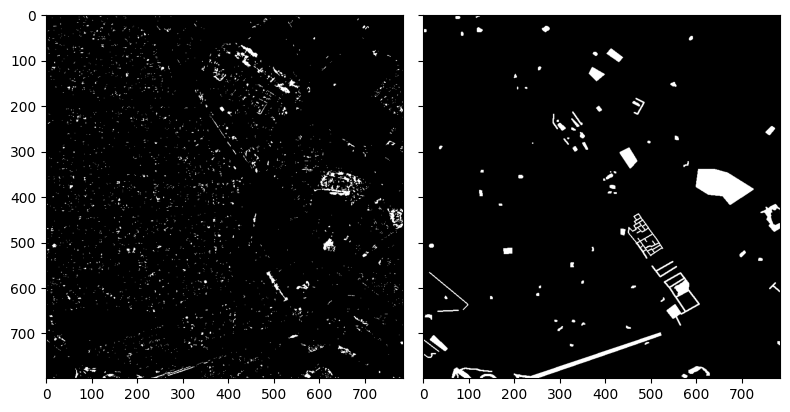

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(8, 8), sharex='all', sharey='all', subplot_kw={'aspect': 'auto'})
axes = axes.flatten()

axes[0].imshow(threshold, cmap='gray')
axes[1].imshow(lab)

plt.tight_layout()
plt.show()

#### 2

In [96]:
def detect_changes_histogram(self, image1, image2):
    
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)
    
    if image1 is None or image2 is None:
        raise ValueError("Failed to load images")
    
    gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
        
    hist1 = cv2.calcHist([image1], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([image2], [0], None, [256], [0, 256])

    diff = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CHISQR)
    return diff

In [97]:
diff = detect_changes(im1_path,im2_path)

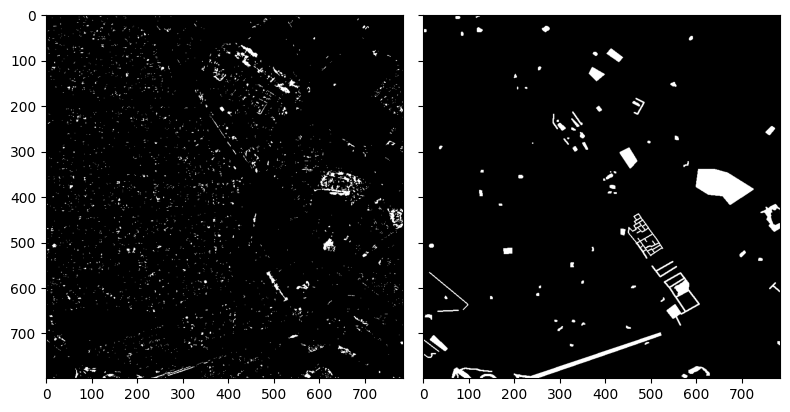

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(8, 8), sharex='all', sharey='all', subplot_kw={'aspect': 'auto'})
axes = axes.flatten()

axes[0].imshow(diff, cmap='gray')
axes[1].imshow(lab)

plt.tight_layout()
plt.show()

#### 3

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dense, Dropout, BatchNormalization, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [11]:
class ChangeDetectionModel:
    def __init__(self, input_shape, activation, loss, method):
        self.input_shape = input_shape
        self.activation = activation
        self.loss = loss
        self.method = method
        self.unet = self.Unet()
        self.model = self.Siamese()
        
    def Unet(self):
        input_ = Input(shape=self.input_shape)
        # encoder
        c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_)
        p1 = MaxPooling2D((2, 2))(c1)
        d1 = layers.Dropout(0.2)(p1)

        c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(d1)
        p2 = MaxPooling2D((2, 2))(c2)
        d2 = layers.Dropout(0.2)(p2)
        
        c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(d2)
        p3 = MaxPooling2D((2, 2))(c3)
        d3 = layers.Dropout(0.2)(p3)

        c4 = Conv2D(256, (2, 2), activation='relu', padding='same')(d3)
        p4 = MaxPooling2D((2, 2))(c4)
        d4 = layers.Dropout(0.3)(p4)

        # neck
        c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(d4)

        # decoder
        u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
        u6 = concatenate([u6, c4])
        d6 = layers.Dropout(0.3)(u6)
        c6 = Conv2D(256, (2, 2), activation='relu', padding='same')(d6)
        
        u7 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c6)
        u7 = concatenate([u7, c3])
        d7 = layers.Dropout(0.2)(u7)
        c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(d7)

        u8 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c7)
        u8 = concatenate([u8, c2])
        d8 = layers.Dropout(0.2)(u8)
        c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(d8)

        u9 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c8)
        u9 = concatenate([u9, c1])
        d9 = layers.Dropout(0.2)(u9)
        c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(d9)

        output_ = Conv2D(1, (1, 1), activation=self.activation)(c9)
        
        model = Model(inputs=[input_], outputs=[output_])
        
        return model

    def Siamese(self):
        input_2015 = Input(shape=self.input_shape, name='2015')
        input_2018 = Input(shape=self.input_shape, name='2018')

        features_2015 = self.unet(input_2015)
        features_2018 = self.unet(input_2018)
        
        method = self.method
        if method == 'difference':
            diff = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([features_2015, features_2018])
            output = Conv2D(1, (1, 1), activation=self.activation)(diff)
        elif method == 'softmax':
            diff = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([features_2018,features_2015])
            output = Conv2D(2, (1, 1), activation=self.activation)(diff)
        elif method == 'concatenate':
            concat = concatenate([features_2015, features_2018])
            x = Conv2D(64, (3, 3), activation='relu', padding='same')(concat)
            output = Conv2D(1, (1, 1), activation='sigmoid')(x)
        elif method == 'divide':
            divide = Lambda(lambda tensors: tensors[0] / (tensors[1] + 1e-6))([features_2015, features_2018])
            output = Conv2D(1, (1, 1), activation='sigmoid')(divide)
        elif method == 'diff_and_concat':
            diff = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([features_2015, features_2018])
            concat = concatenate([features_2015, features_2018, diff])
            x = Conv2D(64, (3, 3), activation='relu', padding='same')(concat)
            output = Conv2D(1, (1, 1), activation='sigmoid')(x)
        
        model = Model(inputs=[input_2015, input_2018], outputs=output)
        model.compile(optimizer='adam', loss=self.loss, metrics=['accuracy'])
        
        return model

    def summary(self):
        self.model.summary()

In [20]:
def count(binary_map):
    unique, counts = np.unique(binary_map, return_counts=True)
    pixel_counts = dict(zip(unique, counts))
    print(pixel_counts)

In [29]:
def plot_change_map(predictions, threshold):
    prediction = np.squeeze(predictions)

    binary_map = (prediction > threshold).astype(np.uint8)
    
    count(binary_map)
    
#     plt.imshow(binary_map,cmap='binary')  # Use gray colormap for binary images
#     plt.axis('off')  # Hide axes
#     plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Predicted Change Map')
    plt.imshow(lab, cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title('Binary Change Map')
    plt.imshow(binary_map.squeeze(), cmap='gray')

    plt.show()

    # Convert binary map to 3-channel image
#     change_map_image = cv2.cvtColor(binary_map)
    
#     plt.imshow(np.squeeze(binary_map), interpolation='nearest')
#     plt.show()
    
    return binary_map

binary_crossentropy <br>
sigmoid

In [13]:
#(height, width, depth, channels)
input_shape = (512, 512, 3)

difference

In [249]:
change_detection_model = ChangeDetectionModel(input_shape,activation='sigmoid',loss='binary_crossentropy', method='difference')

In [122]:
history = change_detection_model.model.fit([imgs2015, imgs2018], cms, epochs=10, validation_split=0.1)

Epoch 1/10
1/1 [==============================] - 135s 135s/step - loss: 0.6952 - accuracy: 0.0198 - val_loss: 0.6928 - val_accuracy: 0.9400
Epoch 2/10
1/1 [==============================] - 124s 124s/step - loss: 0.6940 - accuracy: 0.2831 - val_loss: 0.6923 - val_accuracy: 0.9800
Epoch 3/10
1/1 [==============================] - 122s 122s/step - loss: 0.6931 - accuracy: 0.6408 - val_loss: 0.6918 - val_accuracy: 0.9825
Epoch 4/10
1/1 [==============================] - 126s 126s/step - loss: 0.6924 - accuracy: 0.8724 - val_loss: 0.6913 - val_accuracy: 0.9827
Epoch 5/10
1/1 [==============================] - 126s 126s/step - loss: 0.6918 - accuracy: 0.9541 - val_loss: 0.6908 - val_accuracy: 0.9826
Epoch 6/10
1/1 [==============================] - 126s 126s/step - loss: 0.6912 - accuracy: 0.9751 - val_loss: 0.6903 - val_accuracy: 0.9826
Epoch 7/10
1/1 [==============================] - 126s 126s/step - loss: 0.6906 - accuracy: 0.9796 - val_loss: 0.6898 - val_accuracy: 0.9826
Epoch 8/10
1/

In [127]:
def plot_history(history):
    plt.figure(figsize=(5, 5))

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.legend(loc='upper left')
    plt.show()

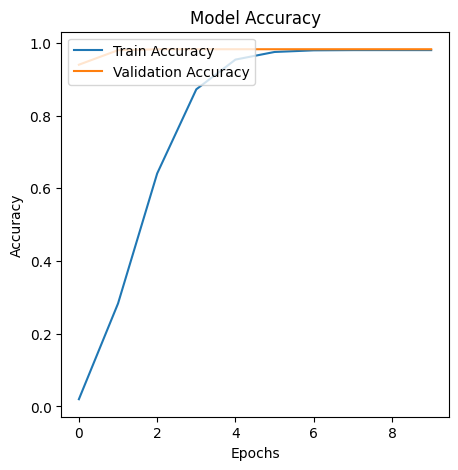

In [128]:
plot_history(history)

In [129]:
predictions = change_detection_model.model.predict([test15,test18])

1/1 [==============================] - 4s 4s/step


In [130]:
predictions

array([[[[0.49754333],
         [0.49753365],
         [0.49756324],
         ...,
         [0.49751112],
         [0.49755594],
         [0.49751616]],

        [[0.49752426],
         [0.49753463],
         [0.49753395],
         ...,
         [0.49750084],
         [0.49752125],
         [0.49751034]],

        [[0.4975254 ],
         [0.4975098 ],
         [0.4975265 ],
         ...,
         [0.49750912],
         [0.49751014],
         [0.49751094]],

        ...,

        [[0.497511  ],
         [0.4975384 ],
         [0.49757934],
         ...,
         [0.49750814],
         [0.4975266 ],
         [0.49753705]],

        [[0.49757266],
         [0.49750686],
         [0.49752185],
         ...,
         [0.49750945],
         [0.4975136 ],
         [0.4975311 ]],

        [[0.49755645],
         [0.4975907 ],
         [0.49762017],
         ...,
         [0.49753785],
         [0.497503  ],
         [0.49752077]]]], dtype=float32)

{0: 255990, 1: 6154}


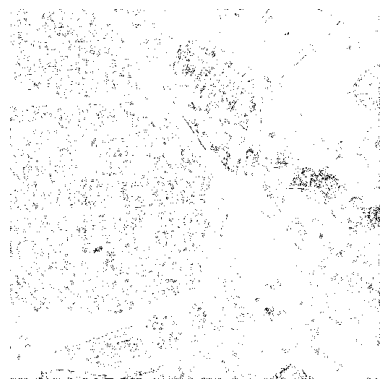

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]], dtype=uint8)

In [152]:
plot_change_map(predictions,0.49759)

sparse_categorical_crossentropy <br> 
softmax

In [276]:
#not work
change_detection_model = ChangeDetectionModel(input_shape,activation='softmax',loss='categorical_crossentropy', method='softmax')

In [267]:
m = predictions > 0.4965
predictions_b = np.where(m.any(axis=-1), m.argmax(axis=-1), 0)

concatenate

In [40]:
change_detection_model = ChangeDetectionModel(input_shape,activation='sigmoid',loss='binary_crossentropy', method='concatenate')

In [41]:
change_detection_model.model.fit([imgs2015, imgs2018], cms, epochs=10, validation_split=0.1)

Epoch 1/10
1/1 [==============================] - 122s 122s/step - loss: 0.7427 - accuracy: 0.0198 - val_loss: 0.7190 - val_accuracy: 0.0174
Epoch 2/10
1/1 [==============================] - 114s 114s/step - loss: 0.7188 - accuracy: 0.0198 - val_loss: 0.6989 - val_accuracy: 0.0193
Epoch 3/10
1/1 [==============================] - 114s 114s/step - loss: 0.6987 - accuracy: 0.0218 - val_loss: 0.6825 - val_accuracy: 0.9788
Epoch 4/10
1/1 [==============================] - 114s 114s/step - loss: 0.6825 - accuracy: 0.9765 - val_loss: 0.6682 - val_accuracy: 0.9788
Epoch 5/10
1/1 [==============================] - 124s 124s/step - loss: 0.6687 - accuracy: 0.9766 - val_loss: 0.6531 - val_accuracy: 0.9808
Epoch 6/10
1/1 [==============================] - 115s 115s/step - loss: 0.6539 - accuracy: 0.9784 - val_loss: 0.6377 - val_accuracy: 0.9826
Epoch 7/10
1/1 [==============================] - 111s 111s/step - loss: 0.6386 - accuracy: 0.9802 - val_loss: 0.6220 - val_accuracy: 0.9826
Epoch 8/10
1/

In [42]:
predictions = change_detection_model.model.predict([test15, test18])

1/1 [==============================] - 3s 3s/step


In [43]:
predictions

array([[[[0.46923816],
         [0.44477224],
         [0.44495437],
         ...,
         [0.44545448],
         [0.44518816],
         [0.4567867 ]],

        [[0.44852406],
         [0.43365705],
         [0.4334223 ],
         ...,
         [0.4341125 ],
         [0.43351805],
         [0.47014984]],

        [[0.44846314],
         [0.43363455],
         [0.43343204],
         ...,
         [0.43399042],
         [0.43364525],
         [0.47014564]],

        ...,

        [[0.4484078 ],
         [0.43385395],
         [0.43384284],
         ...,
         [0.43433133],
         [0.43398517],
         [0.47013888]],

        [[0.44833627],
         [0.43359688],
         [0.43311188],
         ...,
         [0.43342328],
         [0.43304628],
         [0.4697544 ]],

        [[0.47068492],
         [0.46439022],
         [0.46409398],
         ...,
         [0.46397275],
         [0.46381414],
         [0.48786986]]]], dtype=float32)

{0: 235263, 1: 26881}


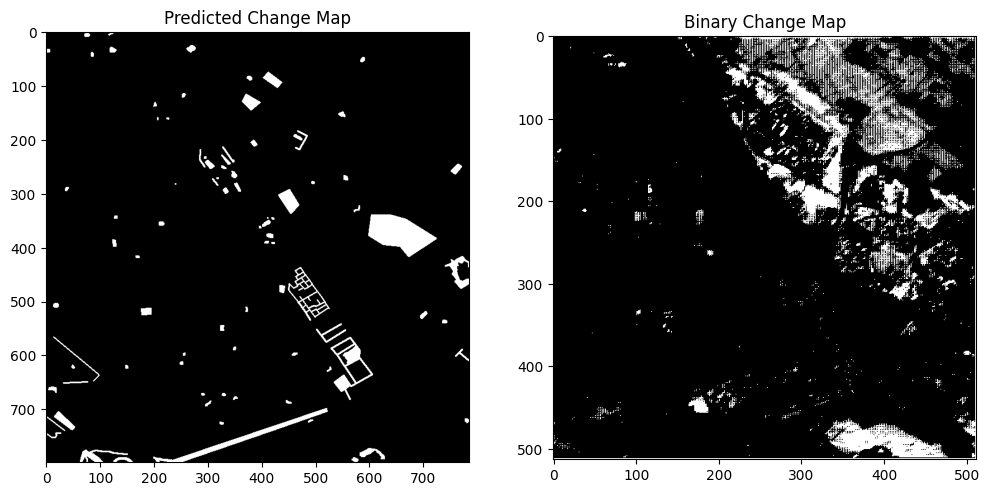

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 0, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [76]:
plot_change_map(predictions,0.434)

divide

In [77]:
change_detection_model = ChangeDetectionModel(input_shape,activation='sigmoid',loss='binary_crossentropy', method='divide')

In [78]:
change_detection_model.model.fit([imgs2015, imgs2018], cms, epochs=10, validation_split=0.1)

Epoch 1/10
1/1 [==============================] - 126s 126s/step - loss: 0.5765 - accuracy: 0.9802 - val_loss: 0.5751 - val_accuracy: 0.9826
Epoch 2/10
1/1 [==============================] - 111s 111s/step - loss: 0.5755 - accuracy: 0.9802 - val_loss: 0.5743 - val_accuracy: 0.9826
Epoch 3/10
1/1 [==============================] - 130s 130s/step - loss: 0.5745 - accuracy: 0.9802 - val_loss: 0.5736 - val_accuracy: 0.9826
Epoch 4/10
1/1 [==============================] - 114s 114s/step - loss: 0.5735 - accuracy: 0.9802 - val_loss: 0.5729 - val_accuracy: 0.9826
Epoch 5/10
1/1 [==============================] - 112s 112s/step - loss: 0.5724 - accuracy: 0.9802 - val_loss: 0.5724 - val_accuracy: 0.9826
Epoch 6/10
1/1 [==============================] - 112s 112s/step - loss: 0.5711 - accuracy: 0.9802 - val_loss: 0.5721 - val_accuracy: 0.9826
Epoch 7/10
1/1 [==============================] - 111s 111s/step - loss: 0.5695 - accuracy: 0.9802 - val_loss: 0.5722 - val_accuracy: 0.9826
Epoch 8/10
1/

In [79]:
predictions = change_detection_model.model.predict([test15, test18])

1/1 [==============================] - 3s 3s/step


In [80]:
predictions

array([[[[0.42935508],
         [0.42804986],
         [0.4282188 ],
         ...,
         [0.4257427 ],
         [0.4263777 ],
         [0.42832083]],

        [[0.42917463],
         [0.42893767],
         [0.4287047 ],
         ...,
         [0.42326567],
         [0.42440358],
         [0.42638117]],

        [[0.4276237 ],
         [0.4270444 ],
         [0.42610985],
         ...,
         [0.4251579 ],
         [0.4265936 ],
         [0.42780086]],

        ...,

        [[0.42298442],
         [0.41433328],
         [0.4156965 ],
         ...,
         [0.40928537],
         [0.4214359 ],
         [0.42460933]],

        [[0.42442095],
         [0.41705218],
         [0.41843107],
         ...,
         [0.41494182],
         [0.42405632],
         [0.42629117]],

        [[0.42711052],
         [0.42224643],
         [0.4223307 ],
         ...,
         [0.4193688 ],
         [0.42568204],
         [0.42722073]]]], dtype=float32)

{0: 235965, 1: 26179}


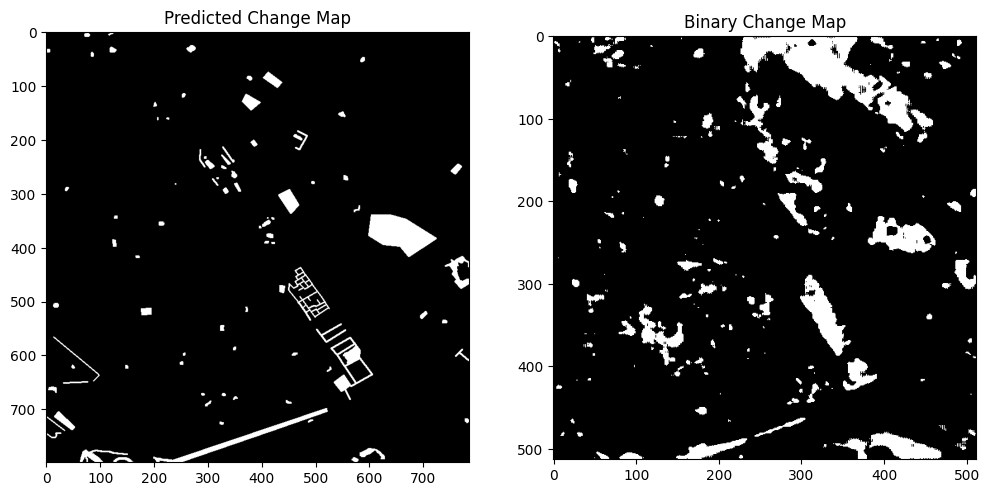

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [90]:
plot_change_map(predictions,0.44)

In [ ]:
change_detection_model.model.save('mm.keras')

In [ ]:
model = tf.keras.models.load_model('mm.keras')